In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize

Using TensorFlow backend.


In [ ]:
#new_saver.save(sess, "../models/niger-current/model")

In [3]:
new_saver = tf.train.import_meta_graph('../models/january-master/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/january-master/'))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/january-master/model
INFO:tensorflow:Restoring parameters from ../models/january-ghana-cocoa/model


In [3]:
# setup function to reproject coordinates
EPSG = CRS.WGS84
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    if 102 <= tl[0] <= 109:
        epsg = 32648 if tl[1] > 0 else 32748
    if 96 <= tl[0] <= 102:
        epsg = 32647 if tl[1] > 0 else 32747
    if 90 <= tl[0] <= 96:
        epsg = 32646 if tl[1] > 0 else 32746
    if 84 <= tl[0] <= 90:
        epsg = 32645 if tl[1] > 0 else 32745
    if 78 <= tl[0] <= 84:
        epsg = 32644 if tl[1] > 0 else 32744
    if 72 <= tl[0] <= 78:
        epsg = 32643 if tl[1] > 0 else 32743
    if 66 <= tl[0] <= 72:
        epsg = 32642 if tl[1] > 0 else 32742
    if 60 <= tl[0] <= 66:
        epsg = 32641 if tl[1] > 0 else 32741
    if 54 <= tl[0] <= 60:
        epsg = 32640 if tl[1] > 0 else 32740
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734
    if 12 <= tl[0] <= 18:
        epsg = 32633 if tl[1] > 0 else 32733
    if 6 <= tl[0] <= 12:
        epsg = 32632 if tl[1] > 0 else 32732
    if 0 <= tl[0] <= 6:
        epsg = 32631 if tl[1] > 0 else 32731
    if -6 <= tl[0] <= 0:
        epsg = 32630 if tl[1] > 0 else 32730
    if -12 <= tl[0] <= -6:
        epsg = 32629 if tl[1] > 0 else 32729
    if -18 <= tl[0] <= -12:
        epsg = 32628 if tl[1] > 0 else 32728
    if -24 <= tl[0] <= -18:
        epsg = 32627 if tl[1] > 0 else 32727
    if -30 <= tl[0] <= -24:
        epsg = 32626 if tl[1] > 0 else 32726
    if -36 <= tl[0] <= -30:
        epsg = 32625 if tl[1] > 0 else 32725
    if -42 <= tl[0] <= -36:
        epsg = 32624 if tl[1] > 0 else 32724
    if -48 <= tl[0] <= -42:
        epsg = 32623 if tl[1] > 0 else 32723
    if -78 <= tl[0] <= -72:
        epsg = 32618 if tl[1] > 0 else 32718
    if -84 <= tl[0] <= -78:
        epsg = 32617 if tl[1] > 0 else 32717
    if -90 <= tl[0] <= -84:
        epsg = 32616 if tl[1] > 0 else 32716
    if -96 <= tl[0] <= -90:
        epsg = 32615 if tl[1] > 0 else 32715
    if -102 <= tl[0] <= -96:
        epsg = 32614 if tl[1] > 0 else 32714
    if -108 <= tl[0] <= -102:
        epsg = 32613 if tl[1] > 0 else 32713
    if -114 <= tl[0] <= -108:
        epsg = 32612 if tl[1] > 0 else 32712
    if -120 <= tl[0] <= -114:
        epsg = 32611 if tl[1] > 0 else 32711
    if -126 <= tl[0] <= -120:
        epsg = 32610 if tl[1] > 0 else 32710
        
        

    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    #EXPANSION = (expansion - np.mean([distance1, distance2]))/2 # should this be 155 or 160?
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    print(after)
    #br = (br[0] + 20, br[1] + 20)
    #tl = (tl[0] - 20, tl[1] - 20)
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

81 64 72 72 289


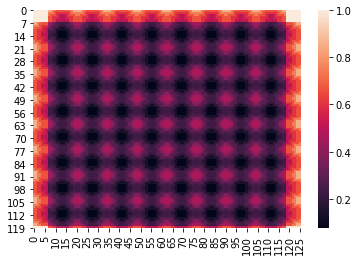

In [4]:
arr = np.array([[1, 1, 2, 2, 3, 3, 3],
                [1, 1, 2, 3, 3, 3, 3],
                [2, 2, 2, 3, 4, 4, 4],
                [2, 3, 3, 3, 4, 5, 6],
                [3, 3, 4, 4, 4, 5, 6],
                [3, 3, 4, 4, 5, 5, 6], 
                [3, 3, 4, 4, 6, 6, 6]])

#arr = np.array(
#      [[0, 0, 0, 0, 0, 0, 0],
#       [0, 1, 1, 1, 1, 1, 1],
#       [0, 1, 2, 2, 2, 2, 2],
#       [0, 1, 2, 3, 3, 3, 3],
#       [0, 1, 2, 3, 4, 4, 4],
#       [0, 1, 2, 3, 4, 5, 5], 
#       [0, 1, 2, 3, 4, 5, 6]])

arr = arr / 6


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)



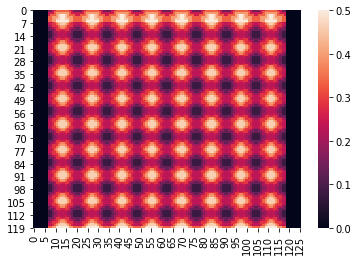

In [5]:
sns.heatmap(right_filter)

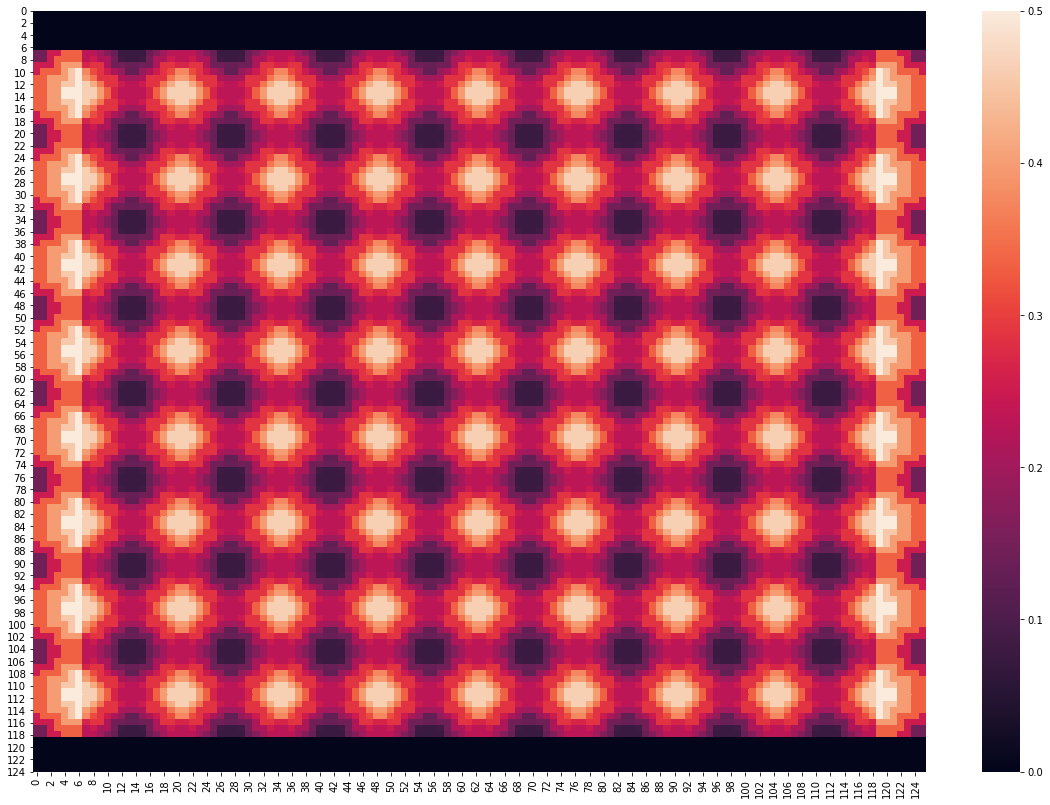

In [6]:
plt.figure(figsize=(20, 14))
sns.heatmap(up_filter)

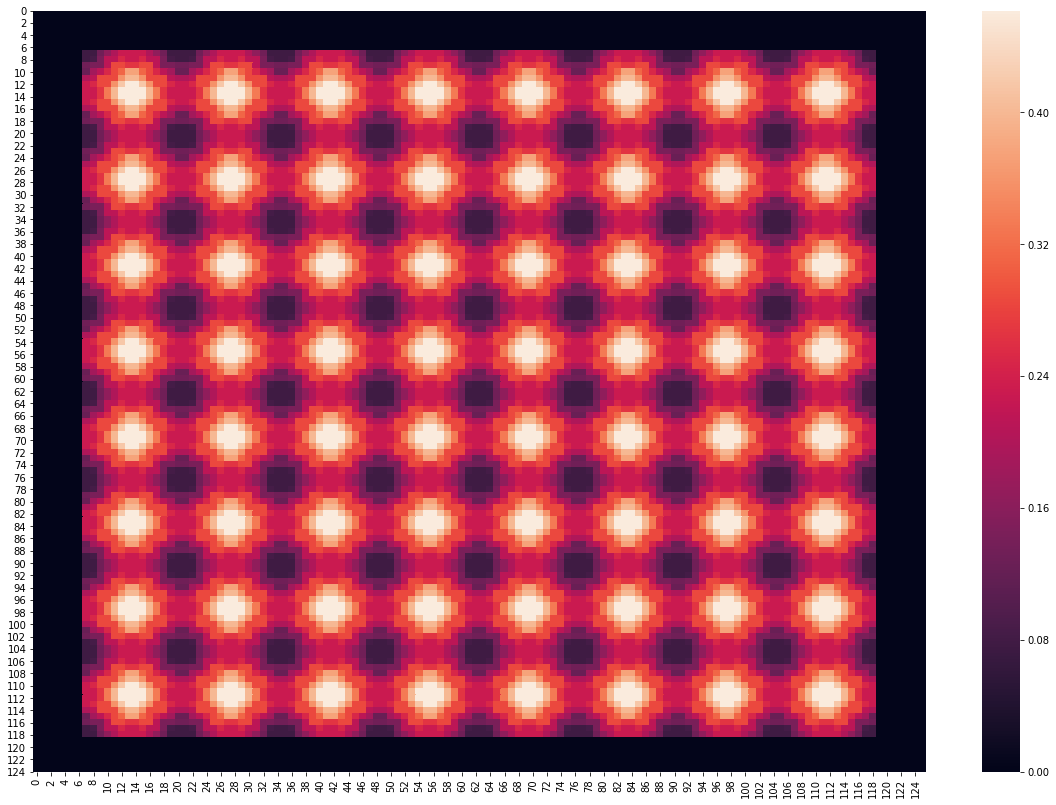

In [7]:
plt.figure(figsize=(20, 14))
sns.heatmap(upright[:, :])

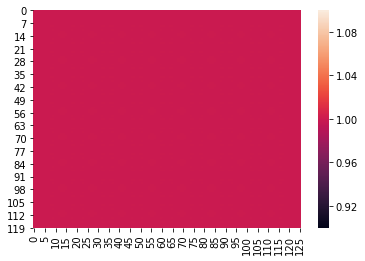

In [8]:
sum_filter = (upright + normal+right_filter + up_filter)# + right_filter + up_filter)
sns.heatmap(sum_filter)

In [9]:
np.tile(np.array(24), (24, 1)).shape

(24, 1)

In [151]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
min_all = [-0.013498377,
 -0.015540331,
 -0.02406282,
 -0.04122347,
 -0.028052842,
 -0.037533052,
 -0.03793668,
 -0.037956487,
 -0.03492851,
 -0.03465478,
 0.0,
 -0.23465249,
 -0.6265123,
 -0.18221906]

max_all = [0.39598167,
 0.45382345,
 0.5510914,
 0.73779887,
 0.5744729,
 0.6185882,
 0.69364935,
 0.75538844,
 0.73705983,
 0.6652184,
 0.7482133,
 1.0674064,
 0.6147919,
 0.8803504]


def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    #pred_files = ["../data/oregon/" + str(y_col) + "/" + str(folder) + "/" + str(x) + ".npy" for x in range(1, TOTAL+1)]
    pred_files = ["../data/brazil/" + str(y_col) + "/" + str(folder) + ".npy"]
    #pred_x = np.empty((0, 24, 16, 16, 14))
    pred_x = []

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, -1, -1)
  
    pred_x = np.stack(x)
        
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, x] = np.clip(pred_x[:, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, x] = standardized
        mins, maxs = (np.min(pred_x[:, :, :, x]), np.max(pred_x[:, :, :, x]))
        
    #stacked = np.max(np.diff(pred_x[:, :, :, 0], axis = 0), axis = (0))
    stacked = np.mean(pred_x[:, :, :, 2], axis = 0)
    #stacked = stacked / sum_filter
    return stacked

In [152]:
x = np.load("../data/malawi/0/0.npy")

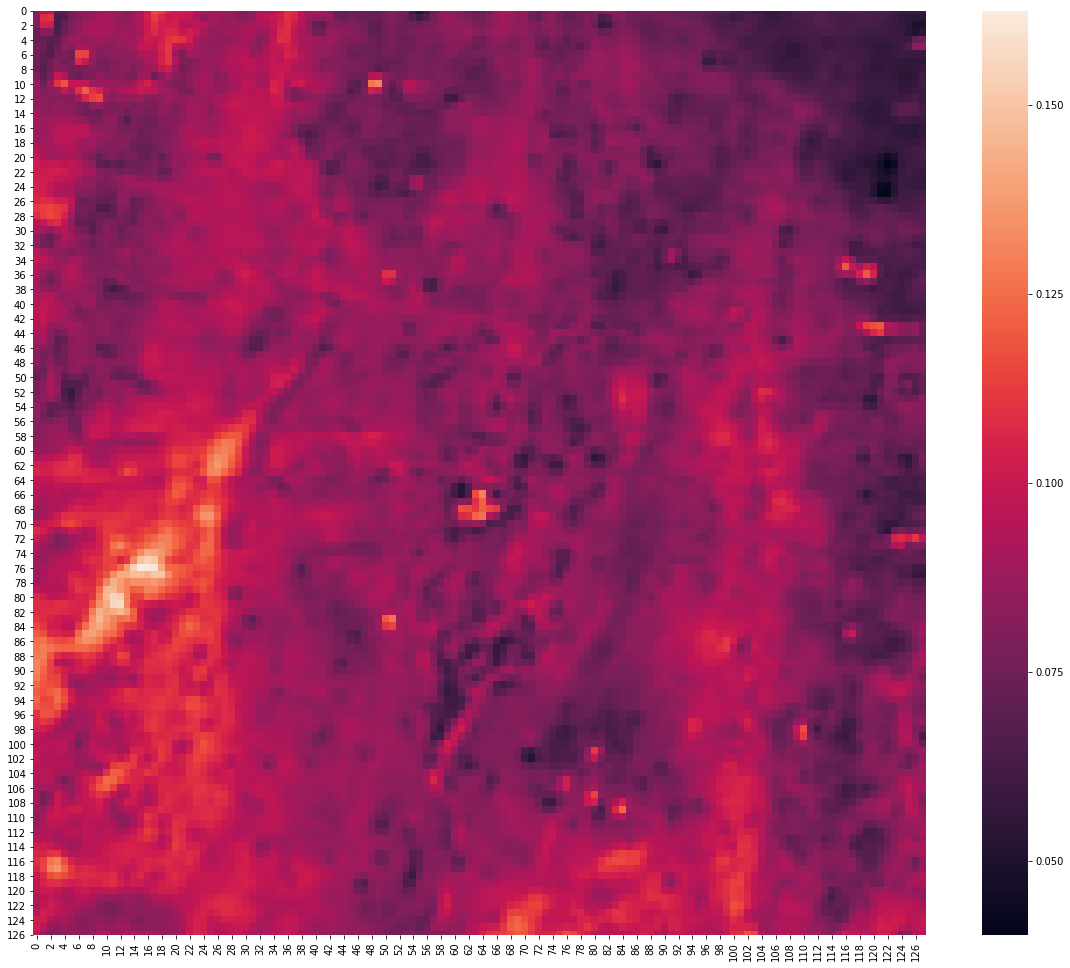

In [153]:
plt.figure(figsize=(20, 17))
sns.heatmap(x[22, :, :, 0])

In [154]:
all_preds = []
for row in tnrange(0,6):
    pred_i = [load_and_predict_folder(row, col) for col in range(0, 6)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)
#stacked, overalpped, up, right = load_and_predict_folder(0, 0)

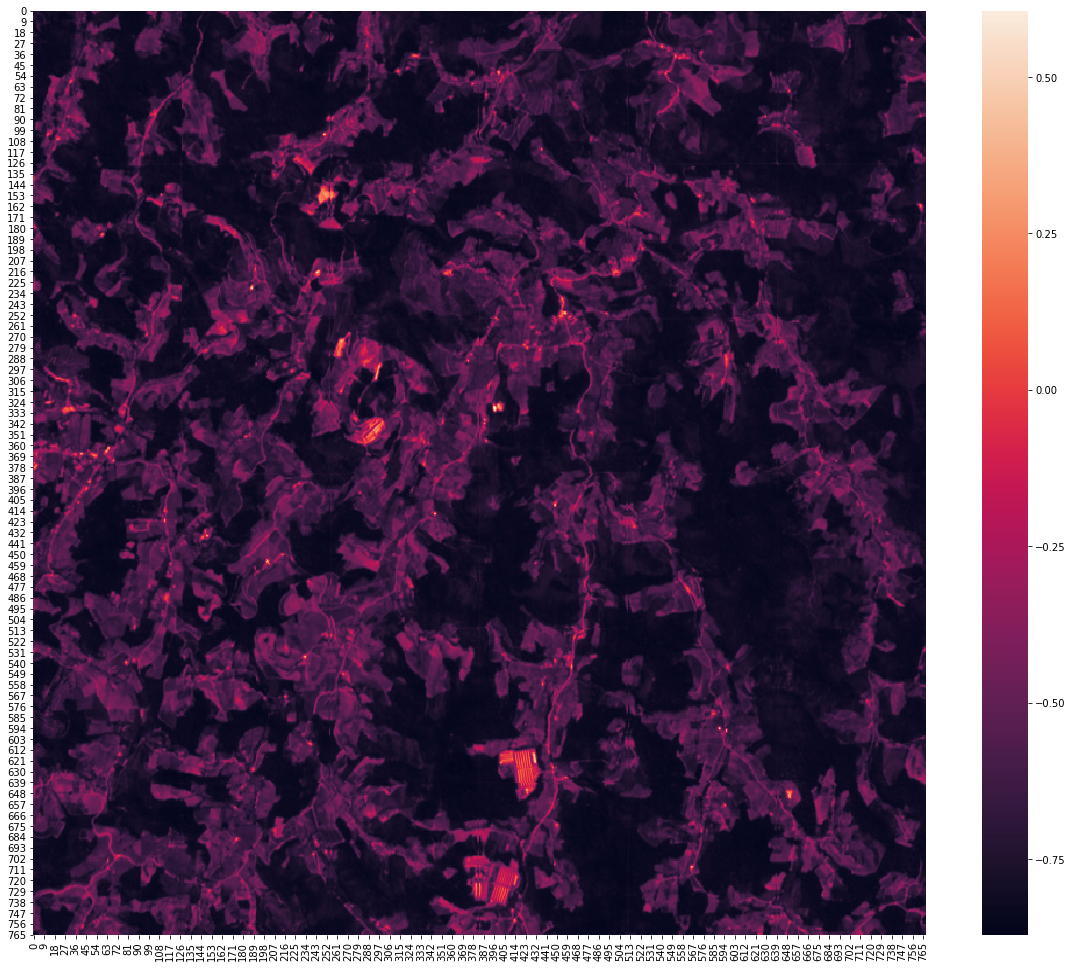

In [155]:
stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 17))
sns.heatmap(stacked)
#plt.savefig('ghana.png', dpi = 300)

In [145]:
thresh = 0.5 # .4, .44 for makueni
thresh_p = 0.6

for window_x in range(2, stacked.shape[0]-2, 1):
    for window_y in range(2, stacked.shape[1]-2, 1):
        cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
        hor_vert_neighbors = False
        if (cur_window[2, 2] > thresh and
            cur_window[2, 2] < thresh_p):
            '''
            n_offenders = 0
            if len(np.argwhere(cur_window[4, 1:4] >= thresh / 2)) != 0:
                n_offenders += 1
                
            if len(np.argwhere(cur_window[0, 1:4] >= thresh / 2)) != 0:
                n_offenders += 1
                
            if len(np.argwhere(cur_window[1:4, 4] >= thresh / 2)) != 0:
                n_offenders += 1
                
            if len(np.argwhere(cur_window[1:4, 4] >= thresh / 2)) != 0:
                n_offenders += 1
            #print(n_offenders)
            if n_offenders == 0:
                print(cur_window)
                n_neigbhors = 0
                if cur_window[1, 2] > thresh and cur_window[1, 2] < thresh_p:
                    n_neigbhors += 1
                if cur_window[2, 1] > thresh and cur_window[2, 1] < thresh_p:
                    n_neigbhors += 1
                if cur_window[2, 3] > thresh and cur_window[2, 3] < thresh_p:
                    n_neigbhors += 1
                if cur_window[3, 2] > thresh and cur_window[3, 2] < thresh_p:
                    n_neigbhors += 1
                #n_neigbhors += len(np.argwhere(cur_window[1, 2]) > thresh)
                #n_neigbhors += len(np.argwhere(cur_window[2, 1]) > thresh)
                #n_neigbhors += len(np.argwhere(cur_window[2, 3]) > thresh)
                #n_neigbhors += len(np.argwhere(cur_window[3, 2]) > thresh)
                print(n_neigbhors)
                if n_neigbhors > 0:
                    if n_neigbhors < 3:
                        stacked[window_x, window_y] = 2.
                        print("Adding")
            '''
            if cur_window[3, 2] > thresh and cur_window[4, 2] < thresh:
                hor_vert_neighbors = True
            if cur_window[1, 2] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
            if cur_window[2, 3] > thresh and cur_window[2, 4] < thresh:
                hor_vert_neighbors = True
            if cur_window[2, 1] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
        
        if hor_vert_neighbors:
            n_offenders = 0
            if cur_window[1, 1] > thresh:
                n_offenders += 1
            if cur_window[3, 3] > thresh:
                n_offenders += 1
            if cur_window[1, 3] > thresh:
                n_offenders += 1
            if cur_window[3, 1] > thresh:
                n_offenders += 1
            if n_offenders < 1:
                print("Adding a tree with: {}".format(cur_window[2, 2]))
                stacked[window_x, window_y] = (thresh_p + 0.01)
                #print(cur_window)

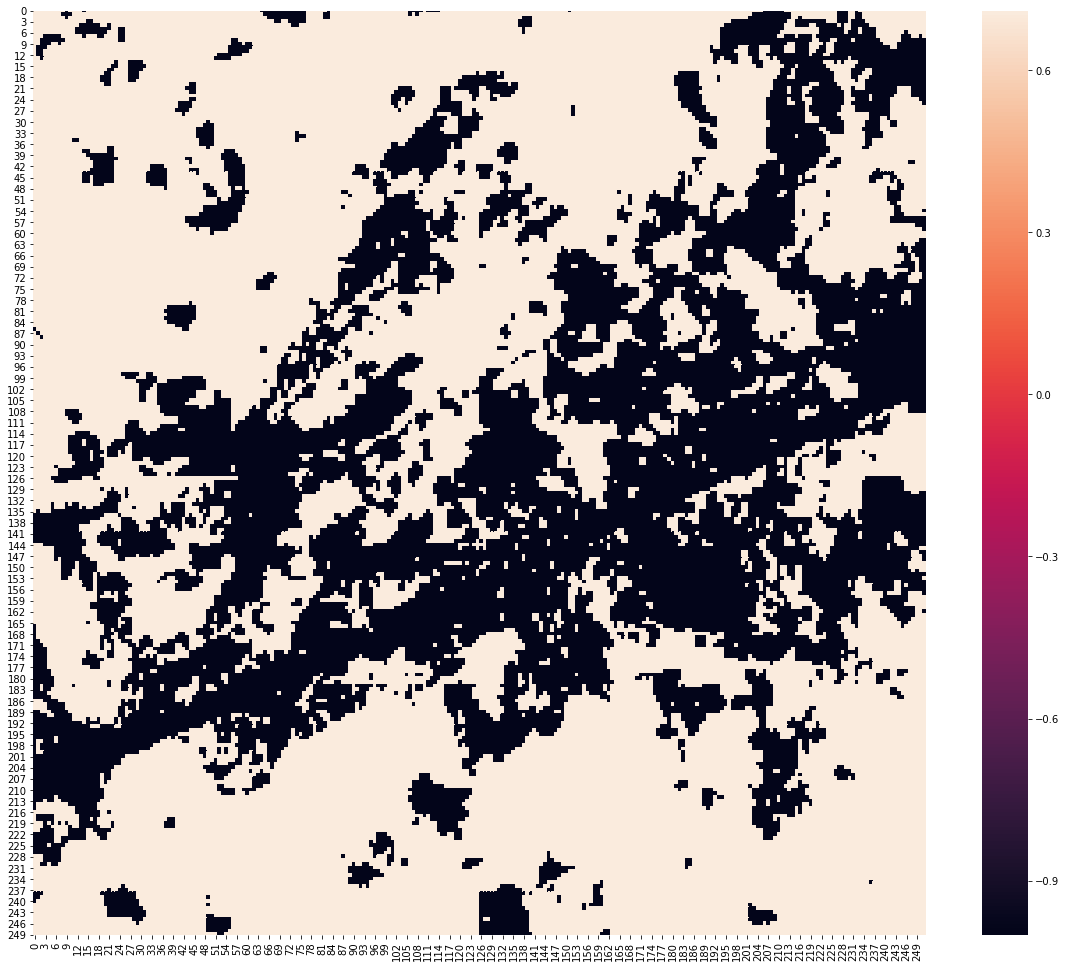

In [27]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 17))
stacked[np.where(stacked > thresh_p)] = 1.
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 0.71
#stacked[np.where(np.logical_and(np.greater_equal(stacked, 0.3), np.greater_equal(0.4, stacked)))] = 0.5
sns.heatmap(stacked)
#plt.savefig('ghana2.png', dpi = 300)

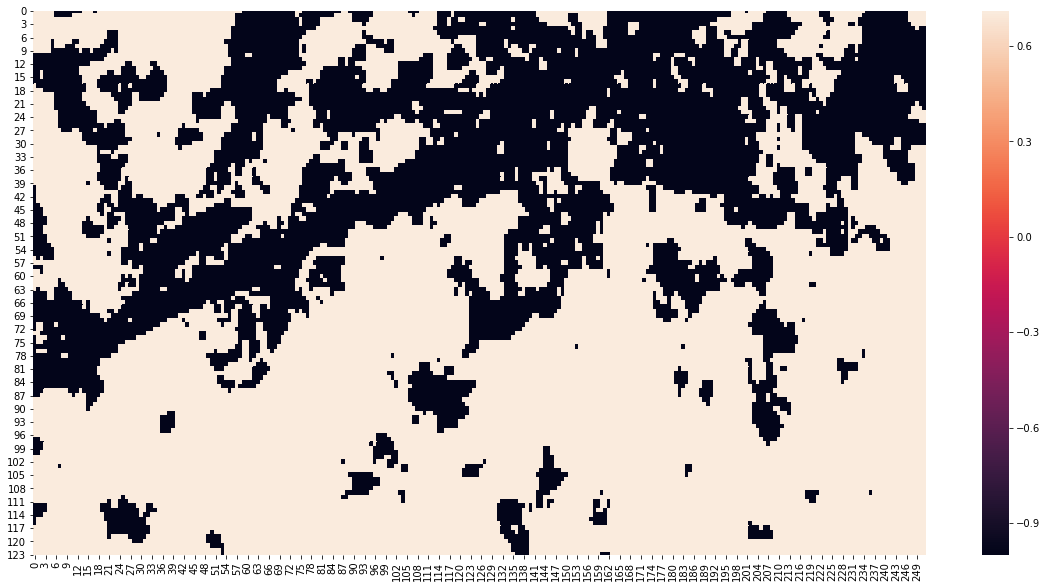

In [34]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 10))
stacked[np.where(stacked > thresh_p)] = 1.
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 0.71
#stacked[np.where(np.logical_and(np.greater_equal(stacked, 0.3), np.greater_equal(0.4, stacked)))] = 0.5
sns.heatmap(stacked)
#plt.savefig('ghana2.png', dpi = 300)

In [28]:
#coords = (13.540810, 38.177220) # tigray
coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (13.316919, 2.581680) # niger
#coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # west mamprusi, ghana
#coords = (10.097017, -2.439068) #uppere west
#coords = (7.398111, -1.269223) # cocoa
#coords = (7.702058, -0.709011) # brong ahafo bono east
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (24.070469, 81.606926) # sidhi, india
coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (44.622690, -124.067024) # usa
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu-large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (6.167177, -75.693226) # medellin, colombia
coords = (coords[1], coords[0])

point = bounding_box(coords, (14*1260)+10, (10*1260)+20, expansion = 0)
coords = (6.518909, -0.826008) # kwahu-large
#coords = (-1.648663, 30.112521) #rwanda
#coords = (11.574298, -12.492513) # guinea
#coords = (5.765917, 14.791618) # baboua, CAF

coords = (coords[1], coords[0])

point = bounding_box(coords, (2*1260)+0, (2*1260)-0, expansion = 0)
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

[2520.0, 2520.0]


In [29]:
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/kwahu.tif', 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

In [122]:
import itertools
def local_sum(arr):
    indices_x = [x for x in range(0, arr.shape[0] - 1, 2)]
    indices_y = [x for x in range(0, arr.shape[1] - 1, 2)]
    perms = [(x, y) for x, y in itertools.product(indices_x, indices_y)]
    #perms = ([list(zip(indices_x, p)) for p in itertools.permutations(indices_y)])
    #perms = [item for sublist in perms for item in sublist]
    #perms = list(set(perms))
    indexes = [([a, a + 2], [b, b + 2]) for a,b in perms]
    #print(perms)
    for i in indexes:
        sub = arr[i[0][0]:i[0][1], i[1][0]:i[1][1]]
        summed = (sum(sum(sub)))
        summed = np.array([[summed for x in range(2)] for y in range(2)])
        arr[i[0][0]:i[0][1], i[1][0]:i[1][1]] = summed
    return arr

In [42]:
summed = local_sum(stacked)
summed[np.where(summed > 1)] = 1

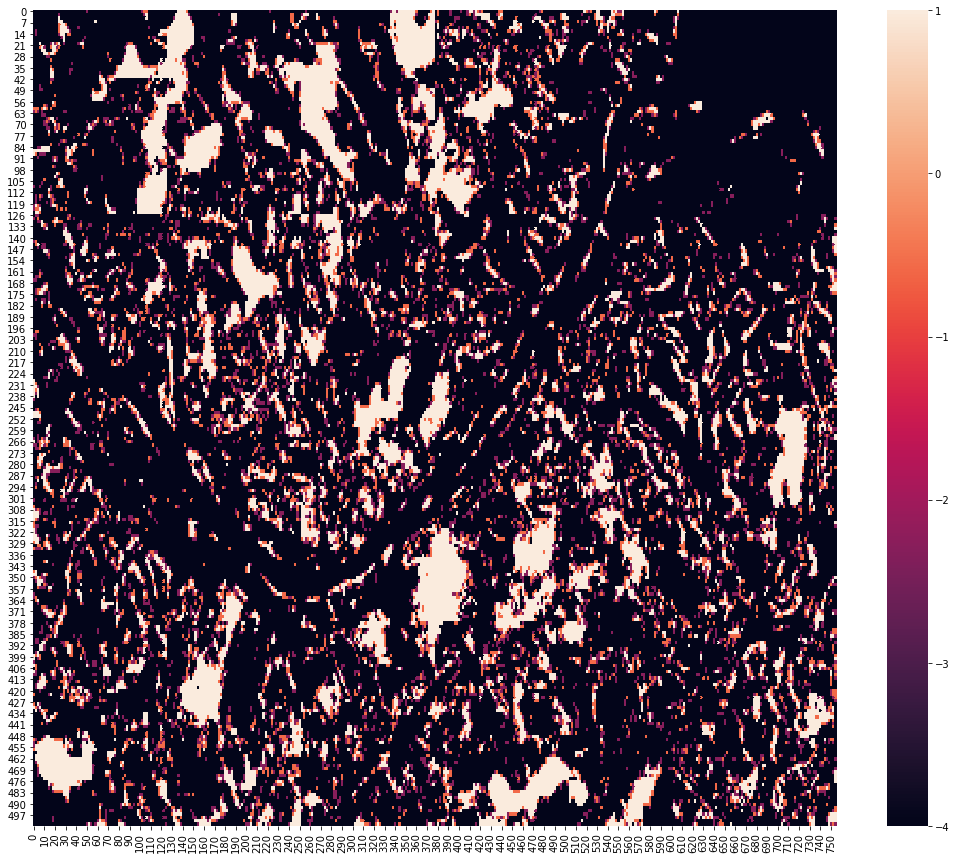

In [853]:
plt.figure(figsize=(18, 15))
sns.heatmap(summed)